 
* Работаем с данными penguins_size.csv. Содержит следующие переменные:

    * species: разновидности пингвинов - Антарктический пингвин (Chinstrap), Пингвин Адели (Adélie) или Папуанский пингвин (Gentoo)
    * culmen_length_mm: длина клюва (mm)
    * culmen_depth_mm: высота клюва (mm)
    * flipper_length_mm: длина крыла (mm)
    * body_mass_g: масса тела (g)
    * island: название острова (Dream, Torgersen или Biscoe) на архипелаге Палмер (Антарктика)
    * sex: пол пингвина

**Наша цель - создать модель, которая поможет нам определять вид пингвина на основе его физических атрибутов, чтобы исследователи могли с помощью этой модели классифицировать пингвинов, без необходимости привлечения опытного биолога.**


In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [55]:
df = pd.read_csv("penguins_size.csv")

In [56]:
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


## Исследование данных - EDA

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [58]:

df.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [59]:
# Удаляем отсутствующие данные, так как их немного
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            334 non-null    object 
 1   island             334 non-null    object 
 2   culmen_length_mm   334 non-null    float64
 3   culmen_depth_mm    334 non-null    float64
 4   flipper_length_mm  334 non-null    float64
 5   body_mass_g        334 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.9+ KB


In [60]:
df['sex'].unique()

array(['MALE', 'FEMALE', '.'], dtype=object)

In [61]:
df[df['sex']=='.']

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,.


In [62]:
df['island'].unique()

array(['Torgersen', 'Biscoe', 'Dream'], dtype=object)

In [63]:
#удаляем строку, которая содержит'.'
df = df[df['sex']!='.']

## Визуализация

<Axes: xlabel='culmen_length_mm', ylabel='culmen_depth_mm'>

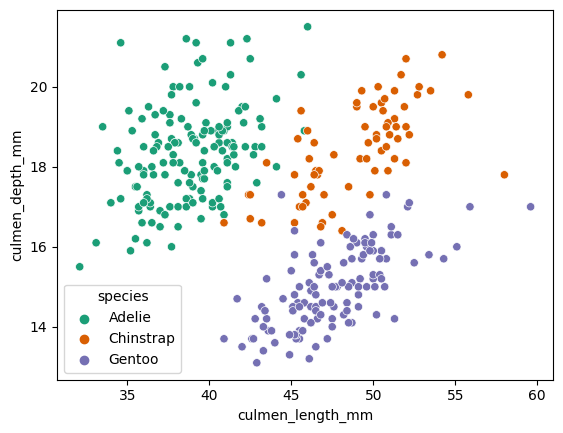

In [64]:
sns.scatterplot(x='culmen_length_mm',y='culmen_depth_mm',data=df,hue='species',palette='Dark2')

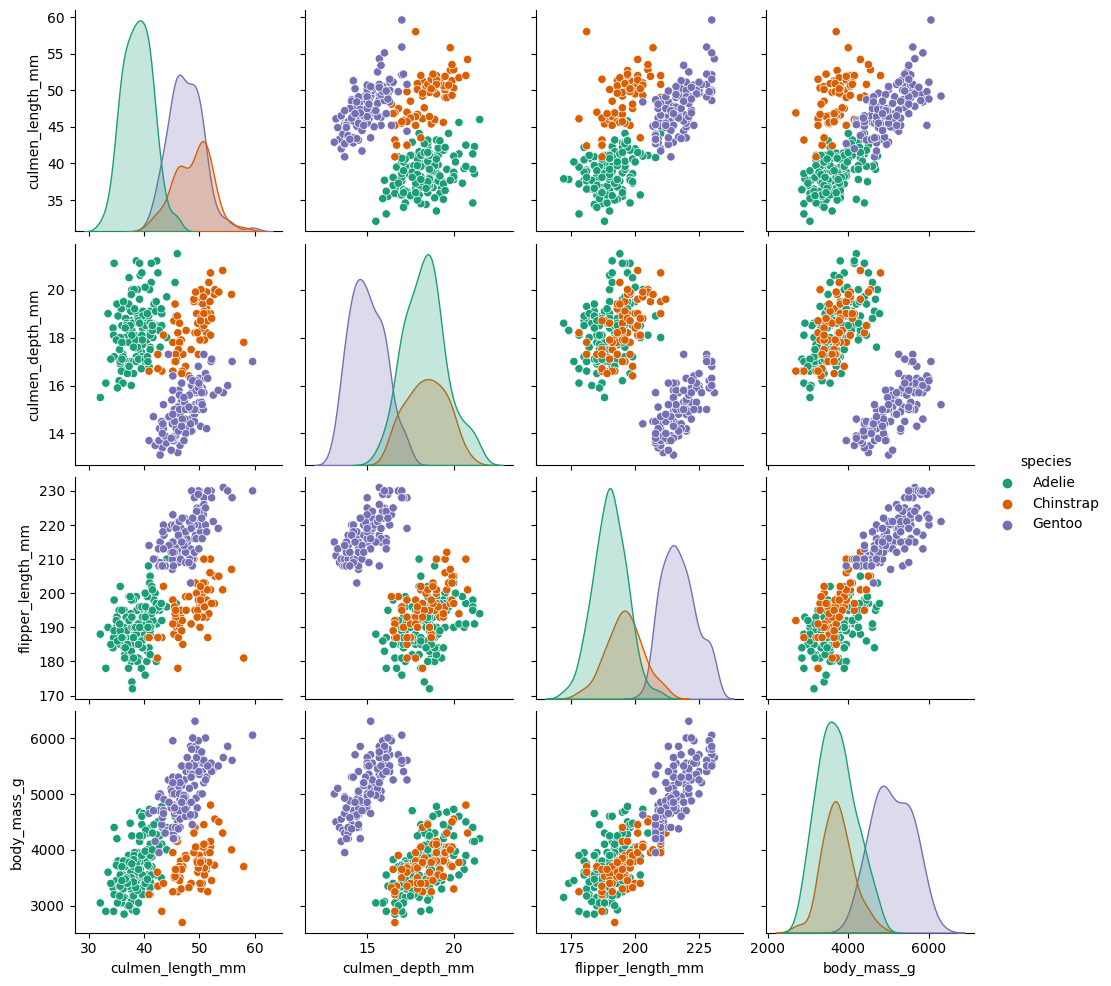

In [65]:
sns.pairplot(df,hue='species',palette='Dark2')

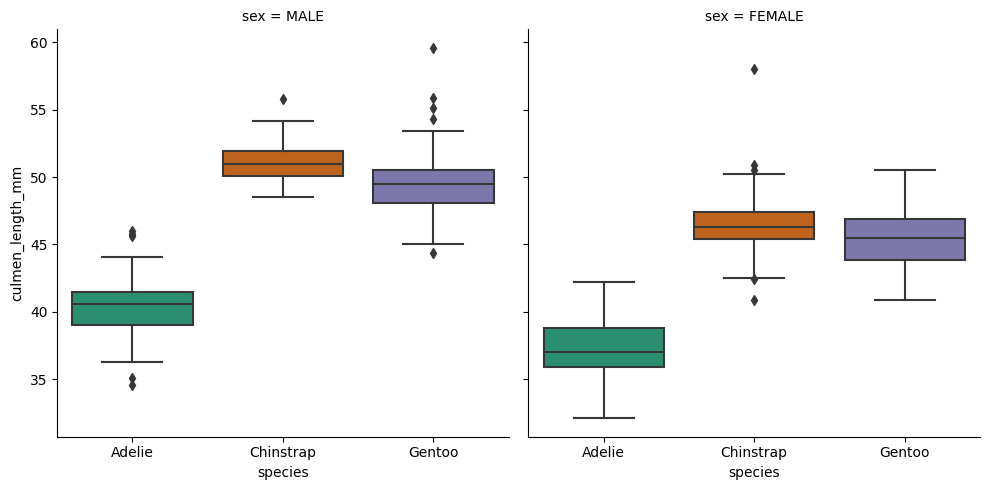

In [66]:
sns.catplot(x='species',y='culmen_length_mm',data=df,kind='box',col='sex',palette='Dark2')

## Построение признаков - Feature Engineering

In [67]:
X = pd.get_dummies(df.drop('species',axis=1),drop_first=True)
y = df['species']
X


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_MALE
0,39.1,18.7,181.0,3750.0,False,True,True
1,39.5,17.4,186.0,3800.0,False,True,False
2,40.3,18.0,195.0,3250.0,False,True,False
4,36.7,19.3,193.0,3450.0,False,True,False
5,39.3,20.6,190.0,3650.0,False,True,True
...,...,...,...,...,...,...,...
338,47.2,13.7,214.0,4925.0,False,False,False
340,46.8,14.3,215.0,4850.0,False,False,False
341,50.4,15.7,222.0,5750.0,False,False,True
342,45.2,14.8,212.0,5200.0,False,False,False


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Классификатор "Дерево решений" - Decision Tree Classifier


In [69]:
#Гиперпараметры по умолчанию
model = DecisionTreeClassifier()
model.fit(X_train,y_train)
base_pred = model.predict(X_test)


In [70]:
# Оцкенка работы модели
confusion_matrix(y_test,base_pred)


array([[38,  2,  0],
       [ 1, 26,  0],
       [ 1,  0, 32]], dtype=int64)

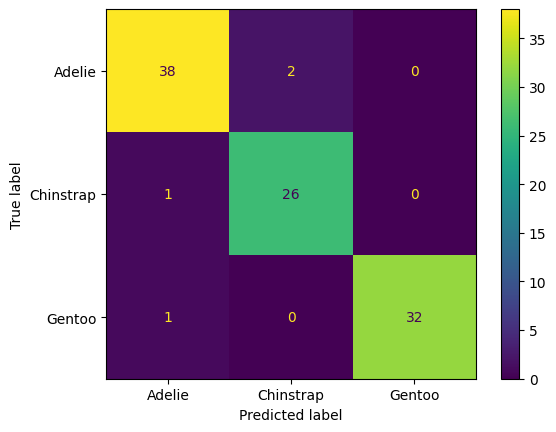

In [71]:
#Визуализируем матрицу ошибок
disp=ConfusionMatrixDisplay.from_estimator(model,X_test,y_test)

In [72]:
print(classification_report(y_test,base_pred))

              precision    recall  f1-score   support

      Adelie       0.95      0.95      0.95        40
   Chinstrap       0.93      0.96      0.95        27
      Gentoo       1.00      0.97      0.98        33

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



In [73]:
# информативность отдельных признаков
#Наибольшую информативность имеет признак flipper_length
pd.DataFrame(index=X.columns,data=model.feature_importances_,columns=['Feature Importance']).sort_values('Feature Importance')

,Feature Importance
body_mass_g,0.000000
island_Torgersen,0.000000
sex_MALE,0.000000
island_Dream,0.044918
culmen_depth_mm,0.045822
culmen_length_mm,0.333501
flipper_length_mm,0.575758


### Визуализация дерева

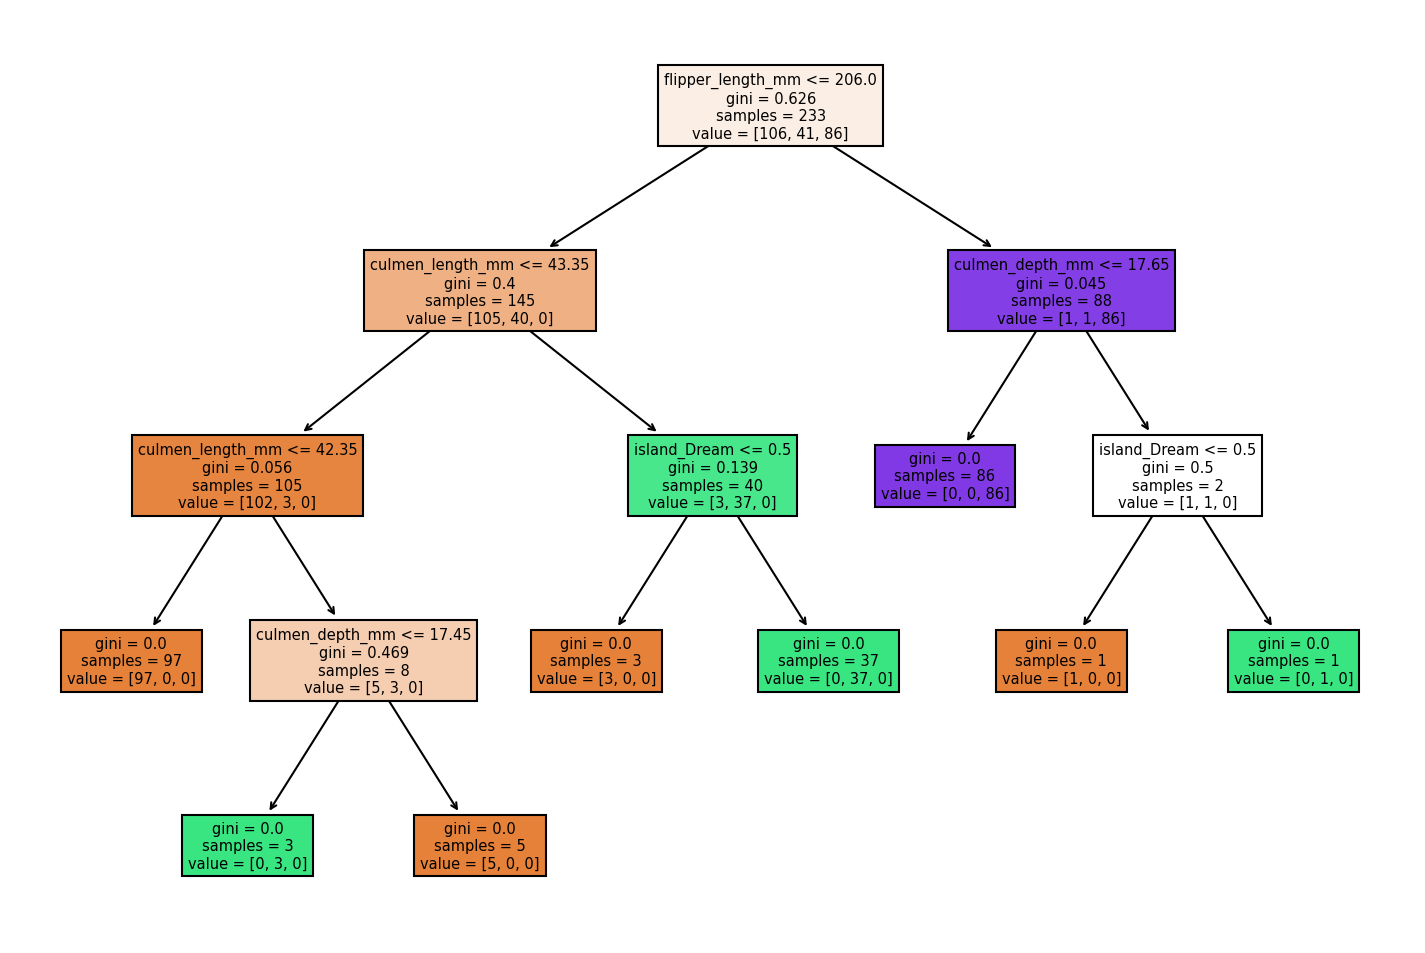

In [74]:
plt.figure(figsize=(12,8),dpi=150)
plot_tree(model,filled=True,feature_names=list(X.columns));

## Случайные леса для классификации - Random Forest Classification

### Для подбора гиперпараметров используем GridSearchCV

In [75]:
n_estimators=[64,100,128,200]
max_features=[2,3,4]
bootstrap=[True,False]
oob_score=[True,False]

In [76]:
param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             'bootstrap':bootstrap,
             'oob_score':oob_score}

In [77]:
model = RandomForestClassifier()
grid=GridSearchCV(model,param_grid)
grid.fit(X_train,y_train)
grid.best_params_


c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python311\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py", line 417, in fit
    raise ValueError("Out of bag estimation only available if bootst

{'bootstrap': False,
 'max_features': 2,
 'n_estimators': 128,
 'oob_score': False}

[[40  0  0]
 [ 1 26  0]
 [ 0  0 33]]
              precision    recall  f1-score   support

      Adelie       0.98      1.00      0.99        40
   Chinstrap       1.00      0.96      0.98        27
      Gentoo       1.00      1.00      1.00        33

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



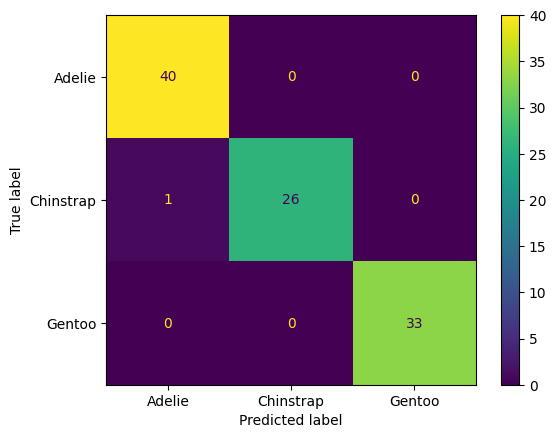

In [78]:
# Оценка работы модели
predictions=grid.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
ConfusionMatrixDisplay.from_estimator(grid,X_test,y_test)


### Построение графика зависимости ошибки от количества деревьев 

По графику видно, что  мы получаем всё меньше пользы при добавлении дополнительных деревьев. По сути уже извлекли всю нужную информацию с помощью примерно 5 деревьев.

In [ ]:
errors = []
misclassifications = []

for n in range(1,64):
    rfc = RandomForestClassifier( n_estimators=n,bootstrap=True,max_features= 2)
    rfc.fit(X_train,y_train)
    preds = rfc.predict(X_test)
    err = 1 - accuracy_score(preds,y_test)
    n_missed = np.sum(preds != y_test) # Более подробно об этой строке кода см. в видео-лекции!!
    errors.append(err)
    misclassifications.append(n_missed)

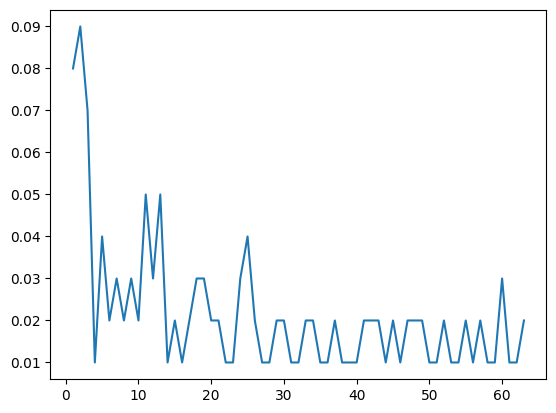

In [ ]:
plt.plot(range(1,64),errors)

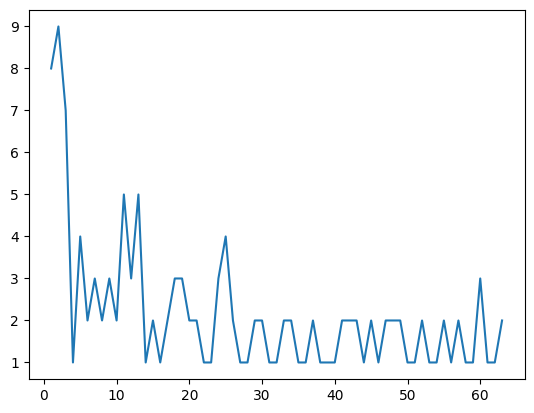

In [ ]:
plt.plot(range(1,64),misclassifications)

### Для подбора гиперпараметров используем hyperopt

In [ ]:
from hyperopt import hp, fmin, tpe,Trials,STATUS_OK
from sklearn.model_selection import cross_val_score

In [ ]:
space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.choice('max_depth', range(1, 10)),
        'max_features': hp.choice('max_features',range(1,10)),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200])
    }

#'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'],
                                    max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'] )
    accuracy = cross_val_score(model, X_train,y_train, cv = 4).mean()

   
    return {'loss': -accuracy,"status":STATUS_OK}

In [ ]:

# Запуск оптимизации
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, trials=trials, max_evals=10)

100%|██████████| 10/10 [00:23<00:00,  2.37s/trial, best loss: -0.9742840444184687]


In [ ]:
print("Лучшие гиперпараметры: ", best)

Лучшие гиперпараметры:  {'criterion': 1, 'max_depth': 6, 'max_features': 3, 'min_samples_leaf': 0.02835196435055093, 'min_samples_split': 0.09513326151089574, 'n_estimators': 3}


## Классификатор Градиентный Бустинг

In [80]:
from sklearn.ensemble import GradientBoostingClassifier

In [81]:
space = {'max_depth': hp.choice('max_depth', range(1, 10)),
        'learning_rate': hp.lognormal ('learning_rate', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200])
    }

In [82]:

def objective(space):
    model = GradientBoostingClassifier(max_depth = space['max_depth'],
                                 learning_rate = space['learning_rate'],
                                 n_estimators = space['n_estimators'] )
    accuracy = cross_val_score(model, X_train,y_train, cv = 4).mean()

   
    return {'loss': -accuracy,"status":STATUS_OK}

In [83]:
# Запуск оптимизации
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, trials=trials, max_evals=10)

100%|██████████| 10/10 [00:28<00:00,  2.83s/trial, best loss: -0.9915254237288136]


In [84]:
print("Лучшие гиперпараметры: ", best)

Лучшие гиперпараметры:  {'learning_rate': 2.94292689738966, 'max_depth': 2, 'n_estimators': 3}


## Классификатор Адаптивный Бустинг

In [92]:
from sklearn.ensemble import AdaBoostClassifier

In [94]:
space = {'learning_rate': hp.lognormal ('learning_rate', 0, 1),
        'n_estimators' : hp.choice('n_estimators', range(1, 300,20))
    }

In [95]:

def objective(space):
    model = AdaBoostClassifier(learning_rate = space['learning_rate'],
                                 n_estimators = space['n_estimators'] )
    accuracy = cross_val_score(model, X_train,y_train, cv = 4).mean()

   
    return {'loss': -accuracy,"status":STATUS_OK}

In [96]:
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, trials=trials, max_evals=10)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [00:08<00:00,  1.16trial/s, best loss: -0.940385739333723]


In [97]:
print("Лучшие гиперпараметры: ", best)

Лучшие гиперпараметры:  {'learning_rate': 1.5351319237625893, 'n_estimators': 6}
